# Fit 2D polynomial to entire slice (single slice)

In [1]:
# Based on the old slice_complete.py and detector_complete.py by ALO
# The idea is to use the refpoint and assigned wavelengths from one isoalpha in one slice to the rest of that slice.
# It completes reference slice
# Then, it extrapolates the results from the reference slice to the rest of slices in the detector
# Does the 2D fit of each slice (individually)

In [1]:
import funcs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
from astropy.io import fits
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [6]:
# directories

# USER:
user = "yannis" # "alvaro","yannis"
# Set work directory
if user == "alvaro":
    workDir = "./"
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

datadir = "data/"
cdpDir = workDir+"cdp_data/"
MRSWaveCalDir = workDir+"MRSWaveCal/" 
FTSlinefits   = MRSWaveCalDir+"FTS_ET_linefits/"

# analysis inputs
band = "1B"
etal = "ET1A" # "ET1A", "ET1B"
ref_alpha = 0.0
ref_sli = 10
islice = 12

# input files
refpoint_file   = 'data/Band'+str(band)+'_SWP_refslice'+str(ref_sli)+'_alpha'+str(ref_alpha)+'_refpoint_'+user+'.txt'
fm_sol_file     = 'data/Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(ref_sli)+'.txt'
pixoffsets_file = 'data/Band'+str(band)+'_SWP_refslice'+str(ref_sli)+'_alpha'+str(ref_alpha)+'_reloffsets.txt'
alpha_tab       = datadir + 'Band'+str(band)+'_'+etal+'_slice'+str(islice)+'.txt'

In [7]:
# Set of reference points
yan_ref = np.loadtxt(refpoint_file,unpack=True,usecols=(0,1), skiprows = 5)
if (ref_alpha == 0.0) & (ref_sli == 10):
    alo_ref = np.array([6.62690523,143.6117457 ])

ref_vals = yan_ref
cutofflamb = ref_vals[0]
cutoffpix = ref_vals[1]

print "Reference Slice = ", ref_sli
print "Reference Alpha = ", ref_alpha
print "Reference Wav   = ", round(cutofflamb,3)
print "Reference Ypix  =", round(cutoffpix,3)

Reference Slice =  10
Reference Alpha =  0.0
Reference Wav   =  6.482
Reference Ypix  = 830.244


In [8]:
# Set of fitted etalon line parameters
refsli_cen_y = np.loadtxt(fm_sol_file,unpack=True,usecols=(0,3), skiprows = 5)[1]
refsli_cen_y = refsli_cen_y[:np.where(np.diff(refsli_cen_y)<0)[0][0]+1]

# FTS Etalon data (need to extrapolate to operating temperatures (~35 K)?)
FTS_ET1A_linefits_file = FTSlinefits+'RAL_FTS_ET1A_FITPARAMS_07.01.00.fits'
FTS_ET1B_linefits_file = FTSlinefits+'RAL_FTS_ET1B_FITPARAMS_07.01.00.fits'

ET1A_linecenters = fits.open(FTS_ET1A_linefits_file)[1].data['LAMCEN'] # [micron]
ET1B_linecenters = fits.open(FTS_ET1B_linefits_file)[1].data['LAMCEN'] # [micron]

if etal == "ET1A":
    refsli_cen_wav = ET1A_linecenters
elif etal == "ET1B":
    refsli_cen_wav = ET1B_linecenters

offsets = np.loadtxt(pixoffsets_file,unpack=True,usecols=(0,1), skiprows = 5)[1]

alpha_pos, xpos_FMetalon1A_peaks, FMetalon1A_peaks, linecenter_ETAL, linefwhm_ETAL, lineskew_ETAL = np.loadtxt(alpha_tab,unpack=True,usecols=(0,1,2,3,4,5), skiprows = 5)

In [9]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
alphaMap  = d2cMaps['alphaMap']
lambdaMap = d2cMaps['lambdaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

In [10]:
# compute slice reference x-position
alpha_img = np.zeros(det_dims)
alpha_img[(sliceMap == 100*int(band[0])+islice)] = alphaMap[(sliceMap == 100*int(band[0])+islice)]
x_coords = np.nonzero(alpha_img[512,:])[0]
alphas = alpha_img[512,:][x_coords]
x_s = interp1d(alphas,x_coords)(0.)

In [11]:
# Translate the wav-pixel reference point to the new slice
ref_new = ref_vals
ref_new[1] = ref_new[1] + offsets[islice-1]

# Search for the nearest y and wavelength to the reference point for ref_alpha (ref_alpha = 0 usually) in the new slice
y_val_ind = funcs.find_nearest(linecenter_ETAL[np.where(alpha_pos == float(ref_alpha))],ref_new[1])
y_val = linecenter_ETAL[y_val_ind]

w_val_ind = funcs.find_nearest(refsli_cen_wav,ref_new[0])
w_val = refsli_cen_wav[w_val_ind]

In [12]:
# Assigns the wavelengths for ref_alpha (ref_alpha = 0 usually) in the new slice
wavelengths = np.empty_like(alpha_pos) * 0.
if y_val > ref_new[1] and w_val < ref_new[0]:
    w_val_ind = w_val_ind + 1
    w_val = refsli_cen_wav[w_val_ind]
if y_val < ref_new[1] and w_val > ref_new[0]:
    w_val_ind = w_val_ind - 1
    w_val = refsli_cen_wav[w_val_ind]

for ylow in range(y_val_ind,-1,-1):
    wavelengths[ylow] = refsli_cen_wav[w_val_ind-(y_val_ind-ylow)]

ggg = y_val_ind + 1
while alpha_pos[ggg] == alpha_pos[ggg-1]:
    wavelengths[ggg] = refsli_cen_wav[w_val_ind+ggg-y_val_ind]
    ggg = ggg + 1

for ooo in [-1,0,1]:
    print wavelengths[y_val_ind+ooo], linecenter_ETAL[y_val_ind+ooo], ref_new

# Creates arrays for the y and wavel of the ref_alpha (ref_alpha = 0 usually) in the new slice
y_alpharef = linecenter_ETAL[:ggg]
wav_alpharef = wavelengths[:ggg]

6.45661957986 823.353578416 [   6.48185116  837.84408986]
6.46983964678 837.353114055 [   6.48185116  837.84408986]
6.48311848993 851.275924705 [   6.48185116  837.84408986]


In [13]:
# Assigns the wavelengths for ALL ALPHAS in the new slice
for aaa in range(ggg,len(alpha_pos)):
# for aaa in np.where(alpha_pos == np.unique(alpha_pos)[0])[0]:
    new_y_val_ind = funcs.find_nearest(y_alpharef,linecenter_ETAL[aaa]) # find etalon line in central trace that is closest to etalon line in nearby slice
    wavelengths[aaa] = wav_alpharef[new_y_val_ind] # assign same wavelength to etalon line in nearby slice as the closest etalon line in the central slice
    # Check for extra etalon line at the end of array
    if wavelengths[aaa] == wavelengths[aaa-1]:
        idx = funcs.find_nearest(refsli_cen_wav,wavelengths[aaa])
        wavelengths[aaa] = refsli_cen_wav[idx+1]

# Saves the wavelengths in a file *wav_sol.txt
save_file = open(datadir + 'Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_wavels.txt', 'w')
save_file.write('# Band '+str(band)+'   Etalon '+ etal[-2:] +'   Slice '+str(islice)+'\n')
save_file.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('#    alpha       x  y      center         FWHM          skewness        wavelength\n')
for zzz in range(0,np.size(FMetalon1A_peaks),1):
    save_file.write(str(alpha_pos[zzz])+'  '+str(int(xpos_FMetalon1A_peaks[zzz]))+'  '+str(int(FMetalon1A_peaks[zzz]))+'  '+str(linecenter_ETAL[zzz])+'  '+str(linefwhm_ETAL[zzz])+'  '+str(lineskew_ETAL[zzz])+'  '+str(wavelengths[zzz])+'\n')
save_file.close()

In [14]:
# Data for 2D polynomial fit:
x = xpos_FMetalon1A_peaks
y = linecenter_ETAL
z = wavelengths

# Fit 2d polynomial to data
try:
    m = funcs.polyfit2d(x_s,x,y,z,2)
except ValueError:
    raise ValueError, "FIT CRASHES FOR SLICE=" + str(islice)

<IPython.core.display.Javascript object>


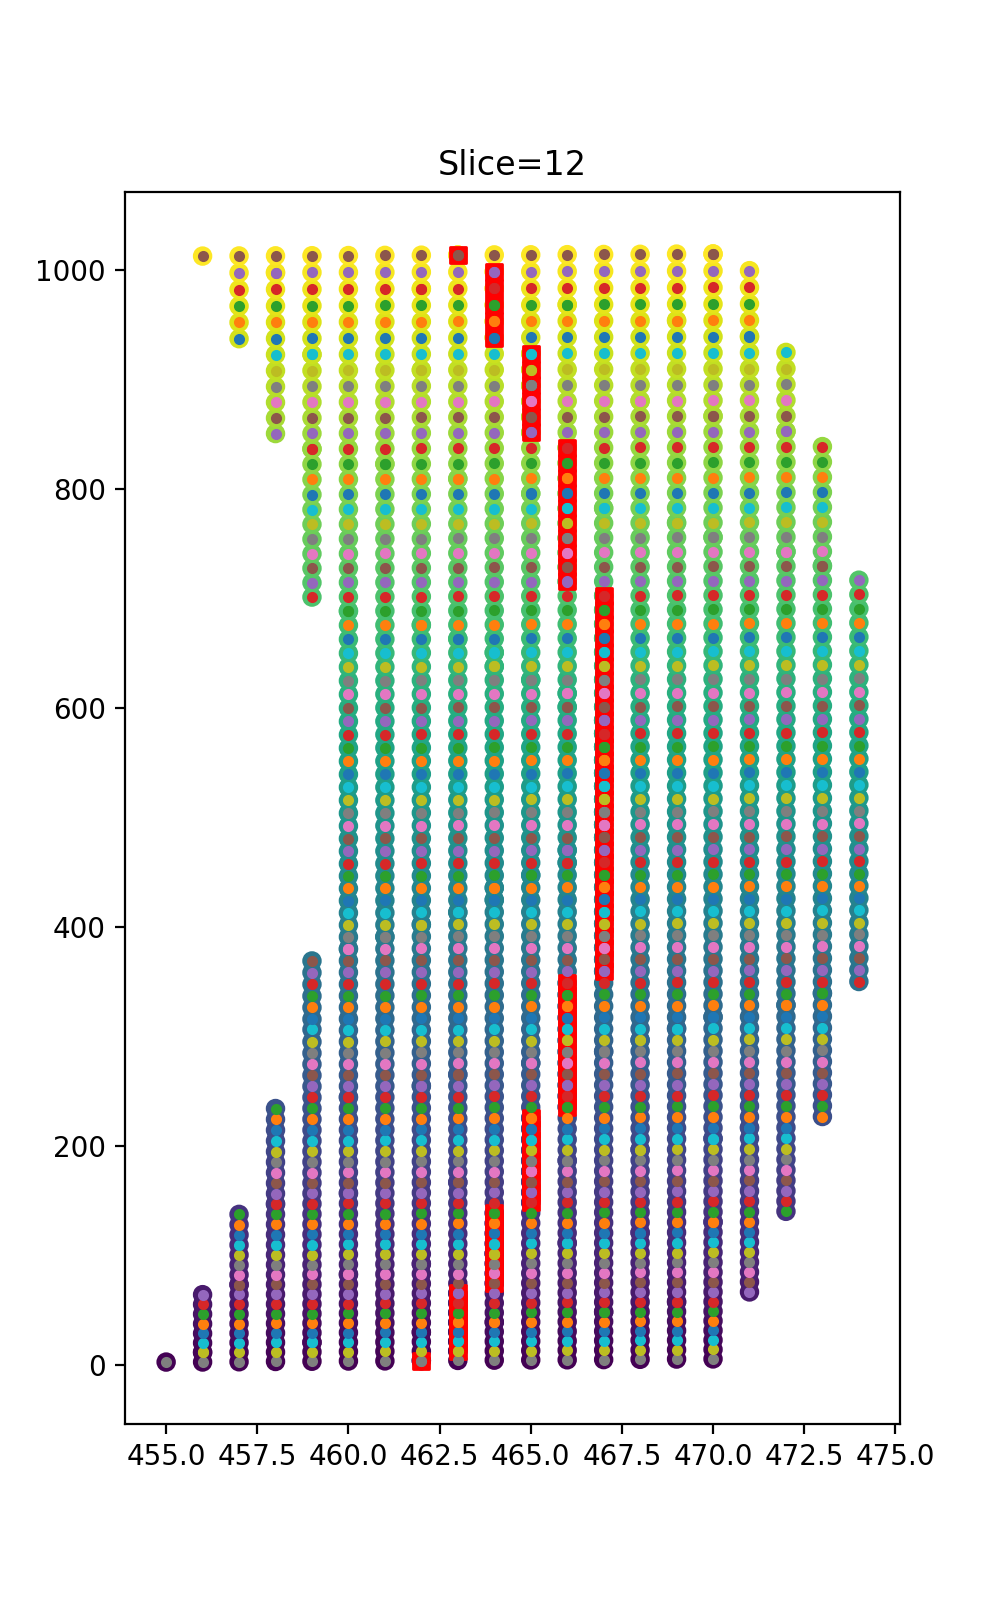

<IPython.core.display.Javascript object>


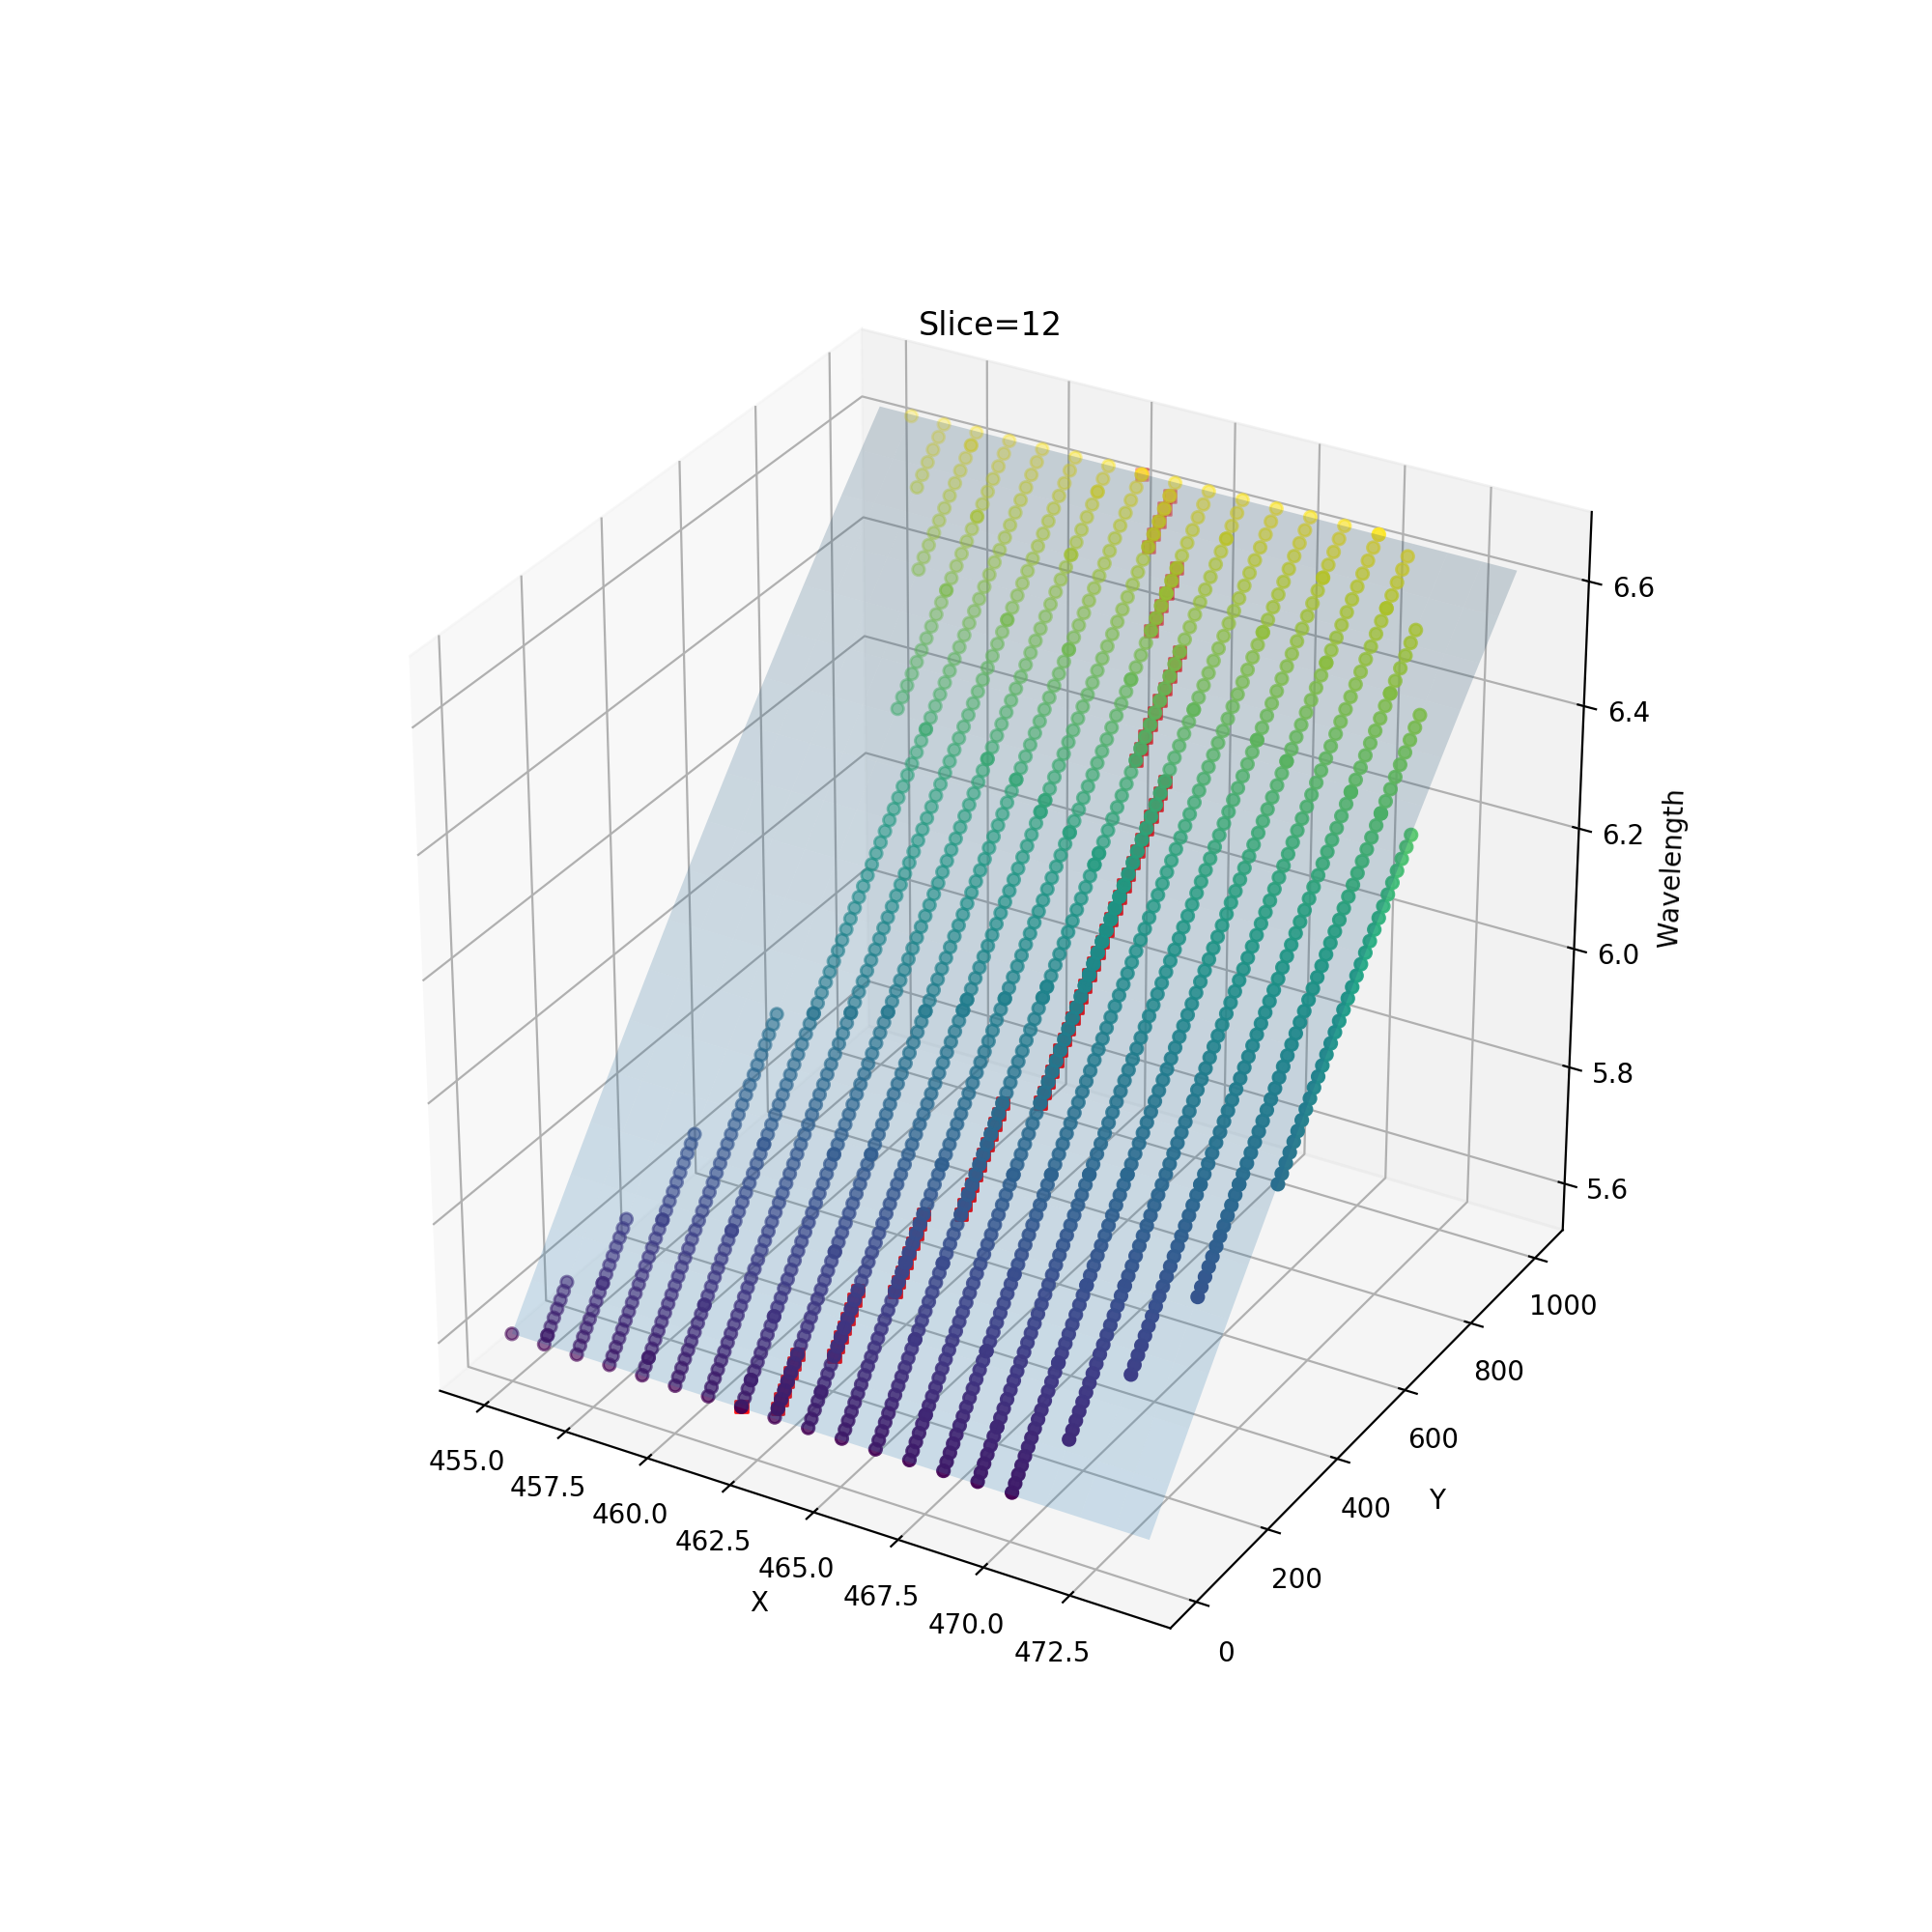

In [15]:
# Evaluate the 2D polynomial fit on a regular grid...
nx, ny = 20, 20
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx),
                     np.linspace(y.min(), y.max(), ny))
zz = funcs.polyval2d(x_s,xx, yy, m)

# Plot trace and isolambda
plt.figure(figsize=(5,8))
plt.title("Slice="+str(islice))
for lll in refsli_cen_wav:
    indices_isolam = np.where(wavelengths == lll)
    x_isolam = x[indices_isolam[0]]
    y_isolam = y[indices_isolam[0]]
    plt.plot(x_isolam,y_isolam,".")
plt.scatter(x,y, c=z)
plt.scatter(x[0:ggg],y[0:ggg], c="r",marker="s")
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, alpha=0.2)
ax.scatter(x,y, z,c=z)
ax.scatter(x[0:ggg],y[0:ggg],z[0:ggg], c="r",marker="s")
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Wavelength')
plt.title("Slice="+str(islice))
ax.axis('equal')
ax.axis('tight')
plt.show()

In [16]:
# Saves the polynomial coefficients
save_file_pol = open(datadir + 'Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_coeffs.txt', 'w')
save_file_pol.write('# Band '+str(band)+'   Etalon '+ etal[-2:] +'   Slice '+str(islice)+'\n')
save_file_pol.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_file_pol.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file_pol.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file_pol.write('# Polynomial coefficients\n')
for mmm in range(0,len(m)):
    save_file_pol.write(str(m[mmm])+"  ")
save_file_pol.close()

print m
# close("all")

print " SLICE_COMPLETE FINISHED <========================="
# http://inversionlabs.com/2016/03/21/best-fit-surfaces-for-3-dimensional-data.html
# https://stackoverflow.com/questions/7997152/python-3d-polynomial-surface-fit-order-dependent

[  5.59363780e+00  -1.89595005e-04   4.62177741e-07   1.15090829e-03
   2.08696604e-08  -6.46736330e-10  -1.24802484e-07   2.19840928e-11
  -2.78442006e-13]
 SLICE_COMPLETE FINISHED <=========================
